In [72]:
# reload import in jupyter
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from resnet import ResNet, BasicBlock, Bottleneck
from torchvision import transforms, datasets

from torchmetrics import Accuracy
from torchinfo import summary


import matplotlib.pyplot as plt
import numpy as np


# ResNet18 form pytorch import 
import torchvision.models as models

In [74]:
# Load the pretrained model from pytorch
model_resnet18 = models.resnet18(pretrained=True)

m:\ML\ML_regs\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
m:\ML\ML_regs\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [75]:
class MNISTNoZero(datasets.MNIST):
    def __init__(self, *args, **kwargs):
        super(MNISTNoZero, self).__init__(*args, **kwargs)
        
        # Filter out indices of all '0' digits
        self.non_zero_indices = [i for i, target in enumerate(self.targets) if target != 0]
        
        # Keep only the data and targets that are not '0'
        self.data = self.data[self.non_zero_indices]
        self.targets = self.targets[self.non_zero_indices] - 1


# Define the preprocessing transformation
transform = transforms.Compose([
    transforms.Resize(256),  # Resize the image to 256x256 pixels
    transforms.CenterCrop(224),  # Crop the center 224x224 pixels of the image
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5,), (0.5,)),  # Normalize the image
    # transforms.Normalize((0.5,), (0.5,)),  # Normalize pixel values
])


# Create training and test datasets without '0' digits
mnist_trainset_no_zero = MNISTNoZero(root='./data', train=True, download=True, transform=transform)

mnist_testset_no_zero = MNISTNoZero(root='./data', train=False, download=True, transform=transform)


# Apply the transformation to your image
# preprocessed_image = transform(image)

In [76]:
train_dataset, val_dataset = torch.utils.data.random_split(mnist_trainset_no_zero, [45077, 9000])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                          shuffle=True, num_workers=0)

# good
testloader = torch.utils.data.DataLoader(mnist_testset_no_zero, batch_size=64,
                                            shuffle=False, num_workers=0)

valloader = torch.utils.data.DataLoader(val_dataset, batch_size=64,
                                            shuffle=False, num_workers=0)

In [20]:
for img, label in trainloader:
    # Try to visualize or print the shape of img here
    print(img.shape)
    break

torch.Size([64, 1, 224, 224])


In [21]:
dataiter = iter(trainloader)
images,  labels = next(dataiter)


In [26]:
images.shape

torch.Size([64, 1, 224, 224])

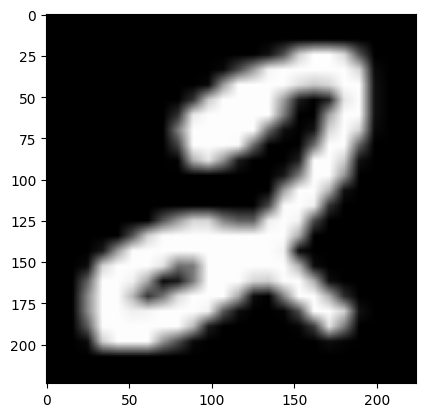

In [22]:

plt.imshow(images[0].squeeze(), cmap='gray')


In [77]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [78]:
accuracy = Accuracy(task='multiclass', num_classes=9)

accuracy = accuracy.to(device)



In [83]:
model_custom_resnet18 = ResNet(BasicBlock, [2, 2, 2, 2])

model_custom_resnet18 = model_custom_resnet18.to(device)

In [80]:
# classes are 9 and channels are 1
model_resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

model_resnet18.fc = nn.Linear(512, 9)

In [71]:
summary(model_custom_resnet18, input_size=(1, 1, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 9]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         3,136
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─Sequential: 1-3                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─Conv2d: 3-3                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-4             [1, 64, 56, 56]           128
│    │    └─Sequential: 3-5              [1, 64, 56, 56]           --
│    └─BasicBlock: 2-2                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-6                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-7             [1, 64, 56, 56]           

In [40]:
summary(model=model_resnet18, input_size=(1, 1, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 9]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         3,136
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

In [59]:
print("ResNet-18 layers:")
for name, child in model_resnet18.named_children():
    print(name, child)

ResNet-18 layers:
conv1 Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
bn1 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
relu ReLU(inplace=True)
maxpool MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
layer1 Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size

In [84]:
criterion = nn.CrossEntropyLoss()
optimizer_adam = optim.Adam(model_custom_resnet18.parameters(), lr=1e-4)

optimizer_sgd = torch.optim.SGD(model_custom_resnet18.parameters(), lr=0.001, momentum=0.9)

In [85]:
num_epochs = 3 

for epoch in range(num_epochs):
    model_custom_resnet18.train()
    train_loss, train_acc = 0, 0

    for images, labels in trainloader:

        images, labels = images.to(device), labels.to(device)

        optimizer_adam.zero_grad() # Zero the gradients

        outputs = model_custom_resnet18(images) # Forward pass

        loss = criterion(outputs, labels) # Calculate the loss
        acc = accuracy(outputs, labels)

        loss.backward() # Backward pass

        optimizer_adam.step() # Update the weights

        train_loss += loss.item()
        train_acc += acc

    train_loss /= len(trainloader)
    train_acc /= len(trainloader)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

Epoch 1/3, Loss: 0.1126, Accuracy: 0.9673
Epoch 2/3, Loss: 0.0378, Accuracy: 0.9890
Epoch 3/3, Loss: 0.0269, Accuracy: 0.9924


In [86]:
torch.save(model_custom_resnet18.state_dict(), 'resnet18_1_to_9_v2.pth')